In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import optuna
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import KNNImputer
import lightgbm as lgb

In [44]:
df_train = pd.read_parquet('P04_TRAIN.pq')
df_test  = pd.read_parquet('P04_TEST.pq')

Для начала я рассмотрел какие типы данных хранят признаки в датасете. Для этого я использовал "df_train.info()" и "df_test.info()". В обоих датасетах присутствует тип object на что я обратил внимание.

In [45]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20138 entries, 0 to 20137
Columns: 416 entries, ID to FEATURE_414
dtypes: float64(373), int64(31), object(12)
memory usage: 63.9+ MB


In [46]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 0 to 9999
Columns: 415 entries, ID to FEATURE_414
dtypes: float64(371), int64(30), object(14)
memory usage: 31.7+ MB


Я собрал все признаки с типом object в отдельный датасет и проверил, занимают ли пустоты больше 5% от всей длины датасета с помощью метода .value_counts(). Таким образом, проверив оба датасета, я обнаружил, что у всех признаков типа object имеются пустоты занимающие более 5% от всей длины датасета. В следствии чего, я решил их удалить из обоих датасетов.

In [47]:
object_columns = df_train.select_dtypes(include=['object'])
object_columns

,ID,FEATURE_26,FEATURE_27,FEATURE_31,FEATURE_33,FEATURE_49,FEATURE_106,FEATURE_121,FEATURE_129,FEATURE_299,FEATURE_300,FEATURE_411
0,1-33725273547,Category_1,Category_1,Category_1,Category_1,None,None,2022-10-28 15:55:51,None,None,Category_2,None
1,1-33165158948,Category_1,Category_2,Category_1,Category_1,None,None,1969-12-12 06:43:12,None,None,Category_2,None
2,1-33270455953,Category_1,Category_1,Category_1,Category_1,None,Y,2022-10-20 22:02:43,None,None,Category_1,None
3,1-32934335615,Category_1,Category_1,Category_1,Category_1,None,Y,1969-12-12 06:43:12,None,None,Category_1,None
4,1-34112605832,Category_1,Category_1,Category_1,Category_1,None,Y,1969-12-12 06:43:12,None,None,Category_2,None
...,...,...,...,...,...,...,...,...,...,...,...,...
20133,1-33194268837,Category_1,Category_1,Category_1,Category_1,None,None,1969-12-12 06:43:12,None,None,Category_1,None
20134,1-33493779388,Category_1,Category_1,Category_1,Category_1,None,Y,1969-12-12 06:43:12,None,None,Category_1,None
20135,1-34046404092,Category_1,Category_1,Category_1,Category_1,None,Y,1969-12-12 06:43:12,None,None,Category_1,None
20136,1-34345700658,Category_1,Category_1,Category_1,Category_1,None,Y,2022-11-09 05:56:40,None,None,Category_1,None


In [48]:
object_columns['FEATURE_300'].value_counts()

FEATURE_300
Category_2    12244
Category_1     5440
Name: count, dtype: int64

In [49]:
object_columns_test = df_test.select_dtypes(include=['object'])
object_columns_test

,ID,FEATURE_26,FEATURE_27,FEATURE_31,FEATURE_33,FEATURE_49,FEATURE_50,FEATURE_53,FEATURE_106,FEATURE_121,FEATURE_129,FEATURE_299,FEATURE_300,FEATURE_411
0,1-35972079318,Category_1,Category_1,Category_1,Category_1,None,None,None,Y,1969-12-12 06:43:12,None,None,Category_1,None
1,1-34716644135,Category_1,Category_1,Category_1,Category_1,None,None,None,Y,1969-12-12 06:43:12,None,None,Category_1,None
2,1-35386843231,Category_1,Category_1,Category_1,Category_1,None,None,None,Y,1969-12-12 06:43:12,None,None,Category_1,None
3,1-34839475238,Category_1,Category_1,Category_1,Category_1,None,None,None,None,1969-12-12 06:43:12,None,None,Category_2,None
4,1-35362151316,Category_1,Category_1,Category_1,Category_1,None,None,None,None,1969-12-12 06:43:12,None,None,Category_2,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1-35319560769,Category_1,Category_1,Category_1,Category_1,None,None,None,Y,2022-11-26 01:42:38,None,None,Category_1,None
9996,1-35169489475,Category_1,Category_1,Category_1,Category_1,None,None,None,Y,1969-12-12 06:43:12,None,None,Category_1,None
9997,3-34780356093,Category_1,Category_1,Category_1,Category_1,None,None,None,None,1969-12-12 06:43:12,None,None,Category_2,None
9998,3-34798051102,Category_1,Category_1,Category_1,Category_1,None,None,None,Y,1969-12-12 06:43:12,None,Category_2,Category_1,None


In [50]:
object_columns_test['FEATURE_33'].value_counts()

FEATURE_33
Category_1    9976
Category_2      19
Category_3       1
Name: count, dtype: int64

In [51]:
df_train.drop(['FEATURE_26', 'FEATURE_27', 'FEATURE_31', 'FEATURE_33', 'FEATURE_49', 'FEATURE_106', 'FEATURE_129', 'FEATURE_299', 'FEATURE_300', 'FEATURE_411', 'ID', 'FEATURE_121'], axis = 1, inplace = True)
df_test.drop(['FEATURE_26', 'FEATURE_27', 'FEATURE_31', 'FEATURE_33', 'FEATURE_49', 'FEATURE_50', 'FEATURE_53', 'FEATURE_106', 'FEATURE_129', 'FEATURE_299', 'FEATURE_300', 'FEATURE_411', 'FEATURE_121'], axis = 1, inplace = True)
ID = df_test['ID']

Следующий шаг, я разеделил df_train датасет на Х и у.

In [53]:
X = df_train.drop('TARGET', axis=1)
y = df_train['TARGET']

Для очистки данных, содержащихся в двух датасетах (X и df_test), я удаляю столбцы, которые содержат только нулевые значения. 

In [54]:
# Получаем количество непустых значений в каждом столбце DataFrame X
non_null_counts = X.count()

# Выбираем только те столбцы, количество непустых значений в которых равно нулю
features_with_0_count = non_null_counts[non_null_counts == 0].index.tolist()

# Удаляем столбцы с нулевым количеством непустых значений из DataFrame X
X_cleaned = X.drop(columns=features_with_0_count)

# Аналогичные операции для тестового DataFrame df_test
non_null_counts_test = df_test.count()
features_with_0_count_test = non_null_counts_test[non_null_counts_test == 0].index.tolist()
df_test_cleaned = df_test.drop(columns=features_with_0_count_test)

In [ ]:
Далее мы проверяем на всем датасете есть ли признаки, где пустоты занимают больше 5%.

In [55]:
# Получаем список названий столбцов, в которых есть пропущенные значения
features_with_null = X_cleaned.columns[X_cleaned.isnull().any()].tolist()

# Получаем общее количество строк в DataFrame X_cleaned
total_rows = len(X_cleaned)

# Задаем пороговый процент пропущенных значений, который равен 5%
threshold_percentage = 5

# Создаем пустой список для хранения названий столбцов, которые нужно удалить
remove_features = []

# Проходимся по каждому столбцу, в котором есть пропущенные значения
for feature in features_with_null:
    # Считаем количество пропущенных значений в текущем столбце
    num_missing_values = X_cleaned[feature].isnull().sum()
    
    # Вычисляем процент пропущенных значений относительно общего числа строк
    percentage_missing = (num_missing_values / total_rows) * 100
    
    # Если процент пропущенных значений превышает пороговый процент,
    # добавляем название столбца в список для удаления
    if percentage_missing > threshold_percentage:
        remove_features.append(feature)

# В конце, подсчитываем количество столбцов, которые нужно удалить
len(remove_features)

55

Аналогично для датасета df_test_cleaned

In [56]:
# Получение списка столбцов с пропущенными значениями в тестовом DataFrame
features_with_null_test = df_test_cleaned.columns[df_test_cleaned.isnull().any()].tolist()

# Получение общего числа строк в тестовом DataFrame
total_rows = len(df_test_cleaned)

# Задание порогового процента пропущенных значений
threshold_percentage = 5

# Создание пустого списка для хранения столбцов, подлежащих удалению
remove_features_test = []

# Итерация по столбцам с пропущенными значениями в тестовом DataFrame
for feature in features_with_null_test:
    # Подсчет количества пропущенных значений в текущем столбце
    num_missing_values = df_test_cleaned[feature].isnull().sum()
    
    # Вычисление процента пропущенных значений относительно общего числа строк
    percentage_missing = (num_missing_values / total_rows) * 100
    
    # Если процент пропущенных значений превышает пороговый процент,
    # добавление столбца в список для удаления
    if percentage_missing > threshold_percentage:
        remove_features_test.append(feature)

# Подсчет количества столбцов, подлежащих удалению
len(remove_features_test)

34

In [57]:
# Удаляем эти признаки
X_cleaned.drop(remove_features, axis = 1, inplace = True)
df_test_cleaned.drop(remove_features_test, axis = 1, inplace = True)

Так как в датасетах все еще остались пропущенные значения, я использовал импутацию с использованием метода k-ближайших соседей (KNNImputer) для двух датасетов.

In [58]:
# Получение списка столбцов с пропущенными значениями в тренировочных данных
features_with_null = X_cleaned.columns[X_cleaned.isnull().any()].tolist()

# Получение списка столбцов с пропущенными значениями в тестовых данных
features_with_null_test = df_test_cleaned.columns[df_test_cleaned.isnull().any()].tolist()

# Выбор столбцов с пропущенными значениями из тренировочных и тестовых данных
temp = X_cleaned[features_with_null]
temp_test = df_test_cleaned[features_with_null_test]

# Импутация пропущенных значений с использованием KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)

# Применение импутации к тренировочным данным
temp_imputed = knn_imputer.fit_transform(temp)

# Применение импутации к тестовым данным
temp_imputed_test = knn_imputer.fit_transform(temp_test)

# Преобразование импутированных данных обратно в DataFrame
temp_imputed_df = pd.DataFrame(temp_imputed, columns=temp.columns)
temp_imputed_df_test = pd.DataFrame(temp_imputed_test, columns=temp_test.columns)

# Замена столбцов с пропущенными значениями в тренировочных данных импутированными данными
X_cleaned[features_with_null] = temp_imputed_df
X = X_cleaned

# Замена столбцов с пропущенными значениями в тестовых данных импутированными данными
df_test_cleaned[features_with_null_test] = temp_imputed_df_test
df_TEST = df_test_cleaned


Далее я провожу анализ важности признаков (feature importance) путем вычисления chi-squared статистики для контингенционных таблиц, созданных на основе кросс-таблицы между признаками и целевой переменной. Затем результаты анализа сортируются и выводятся в виде DataFrame. Если у признака p-value ниже 0.05, это означает, что признак статистически ценный и соответсвенно остается в датасете.

In [60]:
from scipy.stats import chi2_contingency

contingency_tables = []

# Создание контингенционных таблиц для каждого признака
for feature_column in X.columns:
    contingency_table = pd.crosstab(df_train[feature_column], y)
    contingency_tables.append(contingency_table)

feature_importance_results = []

# Вычисление хи-квадрат статистики и p-значения для каждой контингенционной таблицы
for contingency_table in contingency_tables:
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    feature_importance_results.append({'Feature': contingency_table.index.name, 'Chi-squared': chi2, 'p-value': p_value})

# Создание DataFrame с результатами анализа важности признаков
results_df = pd.DataFrame(feature_importance_results)

# Сортировка результатов по убыванию хи-квадрат статистики
results_df = results_df.sort_values(by='Chi-squared', ascending=False)

# Вывод DataFrame с результатами
print(results_df)


         Feature   Chi-squared   p-value
1      FEATURE_2  20107.000000  0.005048
60   FEATURE_100  20000.861193  0.007292
228  FEATURE_376  20000.861193  0.007292
174  FEATURE_241  19991.371677  0.000612
3      FEATURE_4  19820.915872  0.000159
..           ...           ...       ...
205  FEATURE_290      0.000000  1.000000
165  FEATURE_232      0.000000  1.000000
18    FEATURE_32      0.000000  1.000000
31    FEATURE_55      0.000000  1.000000
177  FEATURE_244      0.000000  1.000000

[237 rows x 3 columns]


In [61]:
significant_features = results_df[results_df['p-value'] < 0.05]['Feature'].tolist()
X = X[significant_features]
TEST = df_TEST[significant_features]

In [64]:
# Разделяю датасет на train и test 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Так как количество признаков все еще велико, я использовал снижение размерности данных с использованием метода главных компонентов (Principal Component Analysis, PCA) и визуализировал объясненную дисперсию (explained variance) в зависимости от числа главных компонент.

In [65]:
# Стандартизируем данные
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_val_std = scaler.transform(X_val)
TEST_std = scaler.transform(TEST)

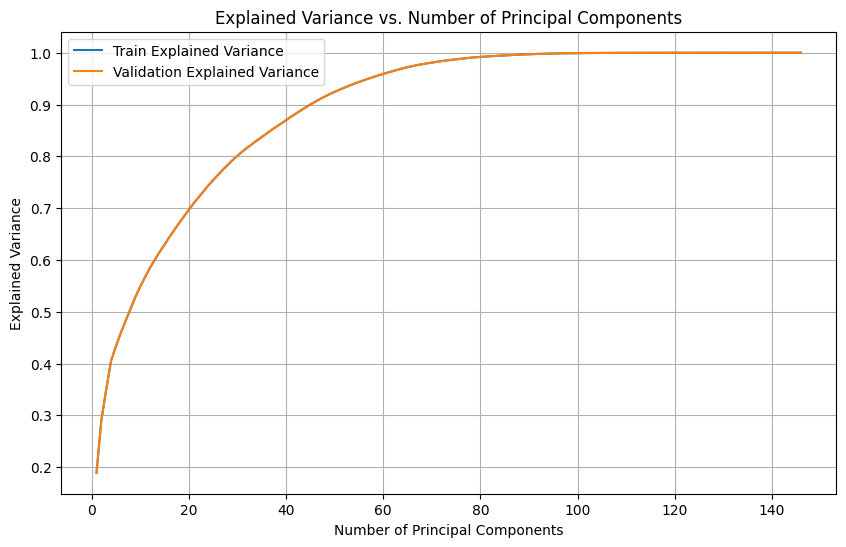

In [66]:
# Создание массива с числом главных компонент
n_components_range = np.arange(1, X_train.shape[1] + 1)

# Создание пустых списков для сохранения объясненной дисперсии
explained_variances_train = []
explained_variances_val = []

# Итерация по числу главных компонент
for n_components in n_components_range:
    # Создание экземпляра PCA с заданным числом компонент
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_std)
    X_val_pca = pca.transform(X_val_std)
    
    # Сохранение суммы объясненной дисперсии для тренировочных и валидационных данных
    explained_variances_train.append(np.sum(pca.explained_variance_ratio_))
    explained_variances_val.append(np.sum(pca.explained_variance_ratio_))

# Создание графика
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, explained_variances_train, label='Train Explained Variance')
plt.plot(n_components_range, explained_variances_val, label='Validation Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance vs. Number of Principal Components')
plt.legend()
plt.grid()
plt.show()

Я выбрал количество признаков равным 80, так как потеря explained variance довольно низка для этого значения.

In [67]:
n_components = 80 
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_std)
X_val_pca = pca.transform(X_val_std)
TEST_pca = pca.transform(TEST_std)

Затем я задаю функцию objective(trial), которая используется в библиотеке Optuna для оптимизации параметров модели LightGBM с использованием метода гиперпараметрической настройки. Здесь происходит задание параметров модели, обучение модели на тренировочных данных, выполнение прогнозов на валидационных данных и вычисление метрики F1-score в качестве меры качества модели. Сперва range для каждого гиперпараметра намного шире, затем впоследствии уменьшал range и результаты метрик улучшались. 

In [69]:
def objective(trial):
    # Определение параметров для настройки
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'n_jobs': -1,
        'num_leaves': trial.suggest_int('num_leaves', 70, 85),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.04, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 700, 800),
        'min_child_samples': trial.suggest_int('min_child_samples', 70, 90),
        'scale_pos_weight': len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
        'max_depth': trial.suggest_int('max_depth', 40, 50),  
        'subsample': trial.suggest_float('subsample', 0.2, 1.0),  
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),  
        'reg_alpha': trial.suggest_float('reg_alpha', 0.6, 0.8),  
        'reg_lambda': trial.suggest_float('reg_lambda', 0.7, 0.9), 
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0), 
        'min_child_weight': trial.suggest_float('min_child_weight', 5, 10),  
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])
    }

    # Создание модели LightGBM с определенными параметрами
    model = lgb.LGBMClassifier(**params)
    
    # Обучение модели на тренировочных данных
    model.fit(X_train_pca, y_train)
    
    # Прогнозирование на валидационных данных
    y_pred = model.predict(X_val_pca)
    
    # Вычисление метрики F1-score
    f1 = f1_score(y_val, y_pred)

    return f1


Этот код использует библиотеку Optuna для запуска процесса гиперпараметрической настройки (hyperparameter tuning) с помощью метода Tree-structured Parzen Estimator (TPE). Он создает экземпляр TPESampler для выбора гиперпараметров, создает Study для отслеживания и оптимизации, и запускает оптимизацию заданного числа раз (n_trials) с целью максимизации определенной целевой функции (objective). 

In [73]:
sampler = optuna.samplers.TPESampler()  
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=100)  

[I 2023-08-17 01:51:22,388] A new study created in memory with name: no-name-580d1524-c6ba-4454-ae25-6573a40db7aa
[I 2023-08-17 01:51:28,755] Trial 0 finished with value: 0.6885245901639343 and parameters: {'num_leaves': 73, 'learning_rate': 0.035760114284312916, 'n_estimators': 740, 'min_child_samples': 76, 'max_depth': 50, 'subsample': 0.4703744640800247, 'colsample_bytree': 0.8462385414215166, 'reg_alpha': 0.7468099676630254, 'reg_lambda': 0.8533585372221243, 'min_split_gain': 0.2534676637419617, 'min_child_weight': 7.834855435125881, 'boosting_type': 'dart'}. Best is trial 0 with value: 0.6885245901639343.
[I 2023-08-17 01:51:29,763] Trial 1 finished with value: 0.7368421052631577 and parameters: {'num_leaves': 84, 'learning_rate': 0.03453576632077495, 'n_estimators': 776, 'min_child_samples': 77, 'max_depth': 47, 'subsample': 0.44439145717945305, 'colsample_bytree': 0.30836050557784483, 'reg_alpha': 0.7343993978483309, 'reg_lambda': 0.7127043979639416, 'min_split_gain': 0.10866903

In [74]:
params = study.best_params
params['scale_pos_weight'] = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
model_new = lgb.LGBMClassifier(**params)
model_new.fit(X_train_pca, y_train)
y_pred_new = model_new.predict(X_val_pca)

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 108, number of negative: 16002
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 16110, number of used features: 80
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006704 -> initscore=-4.998338
[LightGBM] [Info] Start training from score -4.998338
[LightGBM] [Warning] No further splits with posit

In [75]:
print("Accuracy:", accuracy_score(y_val, y_pred_new))
print("Precision:", precision_score(y_val, y_pred_new))
print("Recall:", recall_score(y_val, y_pred_new))
print("F1 Score:", f1_score(y_val, y_pred_new))
print("ROC AUC Score:", roc_auc_score(y_val, y_pred_new))

Accuracy: 0.996772591857001
Precision: 0.84
Recall: 0.7
F1 Score: 0.7636363636363636
ROC AUC Score: 0.8494997498749374


In [76]:
TEST_Results = model_new.predict(TEST_pca)

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


In [90]:
df = pd.concat([ID, pd.Series(TEST_Results)], axis=1)

print(df)

                 ID  0
0     1-35972079318  0
1     1-34716644135  0
2     1-35386843231  0
3     1-34839475238  0
4     1-35362151316  0
...             ... ..
9995  1-35319560769  0
9996  1-35169489475  0
9997  3-34780356093  0
9998  3-34798051102  0
9999  1-35424453894  0

[10000 rows x 2 columns]


In [101]:
df.rename(columns={0: 'predicted'}, inplace=True)
df

,ID,predicted
0,1-35972079318,0
1,1-34716644135,0
2,1-35386843231,0
3,1-34839475238,0
4,1-35362151316,0
...,...,...
9995,1-35319560769,0
9996,1-35169489475,0
9997,3-34780356093,0
9998,3-34798051102,0


In [102]:
df.to_csv('P04-ans.csv', index=False)